In [1]:
import os
from modulus.sym.hydra import to_absolute_path
from csv_rw import csv_to_dict
import csv
import numpy as np
import glob
from multiprocessing import Process
from fwdFacingStep import ffs, param_ranges, Re, Ho, Lo
from shortNames import shortNameDict


In [2]:
def readFile(file_path):
    with open(file_path, "r") as datafile:
        data = []
        reader = csv.reader(datafile, delimiter=",")
        for row in reader:
            columns = [row[1]]
            data.append(columns)
        last_row = float(data[-1][0])
        return last_row

In [16]:
# Read and Compare Delta Cp

from os import listdir
from modulus.sym.domain.validator import Validator
from statistics import mean, stdev
from shortNames import name2data


ansysFilePath="./ansysDPsValidation.csv"
resultsFilePath="./results.csv"
outputsPath="./outputs/fwdFacingStep"

dirSkip = [".hydra", "init"]

models = listdir(outputsPath)
models.sort()

# models = ["data1800PlusPhysicsLambda1@500k", "data1800PlusPhysicsLambda1FC@300k"]

dirSkip = [".hydra", "init", "initFC", "vtp"]

diffSumSkip = ["DP 5","DP 36","DP 79","DP 86"]


with open(ansysFilePath, "r") as ansysFile,  open(resultsFilePath, "w") as resultsFile:
        reader = csv.reader(ansysFile, delimiter=",")
        writer = csv.writer(resultsFile, delimiter=",")
        diffDSP= {}
        diffUSP= {}
        diffDCp= {}

        for i, row in enumerate(reader):
            if i == 0:
                # add columns for difference modulus vs ansys
                row.insert(5, "Diff Delta Cp [%]")
                # row.insert(7, "Diff Delta Cptot [%]")
                writer.writerow(row)
            else:
                for model in models:
                        # print(model)
                        if model in dirSkip:
                                # print("skipping ", model)
                                continue
                        
                        monitorFilePath = os.path.join(outputsPath, model, "monitors")
                        # read pressure monitors
                        filePattern="downstreamPressure_" + row[0].replace(" ","") + "_*"
                        monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        DSP=readFile(monitorFile[0])
                        # filePattern="downstreamPressureTot_" + row[0].replace(" ","") + "_*"
                        # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        # DSPtot=readFile(monitorFile[0])
                        filePattern="upstreamPressure_" + row[0].replace(" ","") + "_*"
                        monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        USP=readFile(monitorFile[0])
                        # filePattern="upstreamPressureTot_" + row[0].replace(" ","") + "_*"
                        # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        # USPtot=readFile(monitorFile[0])
                        
                        # calculate modulus pressure drop and difference modulus vs ansys
                        deltaCp=2*(USP-DSP)
                        
                        trueDSP = float(row[5])
                        trueUSP = float(row[6])
                        trueDeltaCp = float(row[4])
                        
                        if row[0] not in diffSumSkip:
                            if model not in diffDSP.keys():
                                diffDSP[model] = [abs(100*(DSP - trueDSP)/trueDSP)]
                            else:
                                diffDSP[model].append(abs(100*(DSP - trueDSP)/trueDSP))
                                
                            if model not in diffUSP.keys():
                                diffUSP[model] = [abs(100*(USP - trueUSP)/trueUSP)]
                            else:
                                diffUSP[model].append(abs(100*(USP - trueUSP)/trueUSP))
                                
                            if model not in diffDCp.keys():
                                diffDCp[model] = [abs(100*(deltaCp - trueDeltaCp)/trueDeltaCp)]
                            else:
                                diffDCp[model].append(abs(100*(deltaCp - trueDeltaCp)/trueDeltaCp))
                                
                        
                        
                        # add modulus results to table
                        # modRow=[row[0] + " " + model] + row[1:4] + [deltaCp] + [diffDeltaCp] + [deltaCptot] + [diffDeltaCptot] + [DSP] + [DSPtot] + [USP] + [USPtot]
                        # writer.writerow(modRow)
            # Add deviation sum
        # firstRow = ["Model", "DSP Mean", "DSP Min", "DSP Max", "USP Mean", "USP Min", "USP Max", "DCp Mean", "DCp Min", "DCp Max"]
        firstRow = ["Arch", "Const.", "$W_d$", "DCp Mean", "DCp Std", "DSP Mean", "DSP Std", "USP Mean", "USP Std"]
        
        writer.writerow(firstRow)
        
        data = []
        
        for model in models:
            if model in dirSkip or "100k" in model.split("@")[-1] or "300k" in model.split("@")[-1]:
            # if model in dirSkip:
                # print("skipping ", model)
                continue
            
            # maxDSP = max(diffDSP[model])
            # maxUSP = max(diffUSP[model])
            # maxDCp = max(diffDCp[model])

            # minDSP = min(diffDSP[model])
            # minUSP = min(diffUSP[model])
            # minDCp = min(diffDCp[model])
            
            meanDSP = mean(diffDSP[model])
            meanUSP = mean(diffUSP[model])
            meanDCp = mean(diffDCp[model])
            
            stdDSP = stdev(diffDSP[model])
            stdUSP = stdev(diffUSP[model])
            stdDCp = stdev(diffDCp[model])
            
            # modelStrSplit = model.split("@")
                    
            # if len(modelStrSplit) == 3:
            #     label = shortNameDict[modelStrSplit[0]] + shortNameDict[modelStrSplit[1].split("k")[-1]] + "@" + modelStrSplit[1].split("k")[0] + "k"#+ "@" + modelStrSplit[-1]
            # elif len(modelStrSplit) == 2:
            #     label = shortNameDict[modelStrSplit[0]] # + "@" + modelStrSplit[-1]
            
            # modelStrSplit = model.split("@")
                    
            # if len(modelStrSplit) == 3:
            #     arch = shortNameDict[modelStrSplit[0]].split(' ')[0]
            #     train = shortNameDict[modelStrSplit[0]].replace('FD ', '').replace('F ', '').replace()
            #     # shortNameDict[modelStrSplit[1].split("k")[-1]] + "@" + modelStrSplit[1].split("k")[0] + "k"#+ "@" + modelStrSplit[-1]
            # elif len(modelStrSplit) == 2:
            #     label = shortNameDict[modelStrSplit[0]] # + "@" + modelStrSplit[-1]
            
            modelData = name2data(model)
            
            # modelData[]
                
            # row = [label, meanDSP, minDSP, maxDSP, meanUSP, minUSP, maxUSP, meanDCp, minDCp, maxDCp]
            row = [modelData['train'], modelData['Wd'], modelData['2PStep'], modelData['arch'], meanDCp, stdDCp, meanDSP, stdDSP, meanUSP, stdUSP]
            
            data.append(row)
            
        # popsorted=pop[pop[:, -1].argsort()]
        
        # dataSorted = data[data[:,0].argsort()]
        dataSorted = data
        
        for row in dataSorted:
            
            writer.writerow(row)
            # latexStr = label
            latexStr = ''
            for value in row[0:3]:
                # print('f ',value)
                latexStr += str(value) + ' & '
            latexStr += str(row[3])
            for value in row[4:]:
                # print('d ', value)
                valueF = round(float(value), 3)
                # latexStr += "%.3f" % valueF
                latexStr += " & " + "%.3f" % valueF
            latexStr += " \\\\"
            print(latexStr)                    
                                


D+P & 0.1 & 100 & F & 0.971 & 0.868 & 8.912 & 7.411 & 2.192 & 1.740 \\
D+P & 0.1 & 300 & F & 0.950 & 0.703 & 6.634 & 4.811 & 1.670 & 1.257 \\
D+P & 0.1 & - & F & 0.850 & 0.499 & 3.163 & 1.547 & 1.317 & 0.857 \\
D+P & 0.1 & - & FC & 0.249 & 0.243 & 0.346 & 0.421 & 0.168 & 0.180 \\
D+P & 1 & 100 & F & 0.884 & 0.847 & 11.430 & 9.588 & 3.043 & 2.236 \\
D+P & 1 & 300 & F & 1.566 & 1.020 & 10.972 & 6.992 & 3.463 & 2.207 \\
D+P & 1 & - & F & 1.381 & 1.239 & 2.115 & 1.965 & 1.332 & 1.159 \\
D+P & 1 & - & FC & 0.273 & 0.359 & 0.377 & 0.520 & 0.174 & 0.227 \\
D & - & - & F & 5.238 & 5.133 & 10.737 & 7.824 & 5.834 & 5.504 \\
D & - & - & FC & 0.946 & 2.080 & 0.477 & 0.588 & 0.525 & 1.173 \\
P & - & - & F & 1.257 & 1.341 & 8.972 & 8.155 & 2.361 & 1.743 \\
P & - & - & FC & 9.522 & 2.474 & 19.391 & 8.970 & 1.737 & 1.686 \\
P & - & - & FC & 7.957 & 2.008 & 18.308 & 8.219 & 1.389 & 1.485 \\
P & - & - & F & 1.370 & 1.400 & 8.433 & 7.449 & 2.158 & 1.481 \\
PD+P & 1 & - & F & 3.392 & 3.448 & 3.357 & 2.061

In [1]:
models = ["data1800PlusPhysicsLambda1@500k", "data1800PlusPhysicsLambda1FC@300k"]
from shortNames import name2data


for model in models:
    modelData = name2data(model)
    print(modelData.keys())
    for key in modelData:
        print(modelData[key])


dict_keys(['arch', 'train', 'Wd', '2P'])
F
D+P
1
False
dict_keys(['arch', 'train', 'Wd', '2P'])
FC
D+P
1
False


In [24]:
# Read and Compare Delta Cp OLD

from os import listdir
from modulus.sym.domain.validator import Validator


ansysFilePath="./ansysDPsValidation.csv"
resultsFilePath="./results.csv"
outputsPath="./outputs/fwdFacingStep"

# models = ["old_dataPlusPhysics3600@300k", "data3600PlusPhysicsLambda05@300k", "data3600PlusPhysicsLambda1@300k", "old_physicsOnly@500k", "physicsOnly@500k"]

dirSkip = [".hydra", "init"]

models = listdir(outputsPath)
models.sort()

models = ["data1800PlusPhysicsLambda01@500k"]


diffSumSkip = ["DP 5","DP 36","DP 79","DP 86"]


with open(ansysFilePath, "r") as ansysFile,  open(resultsFilePath, "w") as resultsFile:
        reader = csv.reader(ansysFile, delimiter=",")
        writer = csv.writer(resultsFile, delimiter=",")
        diffDict= {}
        for model in models:
                diffDict[model] = 0
                # print(type(diffDict[model]))
        for i, row in enumerate(reader):
                if i == 0:
                        # add columns for difference modulus vs ansys
                        row.insert(5, "Diff Delta Cp [%]")
                        # row.insert(7, "Diff Delta Cptot [%]")
                        writer.writerow(row)
                else:
                        # add ansys results to table
                        row.insert(5, "-")
                        # row.insert(7, "-")
                        writer.writerow(row)
                        for model in models:
                                print(model)
                                if model in dirSkip:
                                        print("skipping ", model)
                                        continue
                                
                                monitorFilePath = os.path.join(outputsPath, model, "monitors")
                                # read pressure monitors
                                filePattern="downstreamPressure_" + row[0].replace(" ","") + "_*"
                                monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                DSP=readFile(monitorFile[0])
                                # filePattern="downstreamPressureTot_" + row[0].replace(" ","") + "_*"
                                # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                # DSPtot=readFile(monitorFile[0])
                                filePattern="upstreamPressure_" + row[0].replace(" ","") + "_*"
                                monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                USP=readFile(monitorFile[0])
                                # filePattern="upstreamPressureTot_" + row[0].replace(" ","") + "_*"
                                # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                # USPtot=readFile(monitorFile[0])
                                
                                # calculate modulus pressure drop and difference modulus vs ansys
                                deltaCp=2*(USP-DSP)
                                # deltaCptot=2*(USPtot-DSPtot)
                                deltaCpTrue = float(row[4])
                                diffDeltaCp=100*(deltaCp-deltaCpTrue)/deltaCpTrue
                                # diffDeltaCptot=100*(deltaCptot-float(row[6]))/float(row[6])
                                
                                if row[0] not in diffSumSkip:
                                        diffDict[model] += abs(diffDeltaCp)
                                
                                # add modulus results to table
                                modRow=[row[0] + " " + model] + row[1:4] + [deltaCp] + [diffDeltaCp] + [DSP] + [USP]
                                # modRow=[row[0] + " " + model] + row[1:4] + [deltaCp] + [diffDeltaCp] + [deltaCptot] + [diffDeltaCptot] + [DSP] + [DSPtot] + [USP] + [USPtot]
                                writer.writerow(modRow)
        # Add deviation sum
        for model in models:
                deviationRow = ["Sum " + model] + ["-"] + ["-"] + ["-"] + ["-"] + [diffDict[model]] + ["-"] + ["-"]
                writer.writerow(deviationRow)
                
                                
                                


data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k


In [6]:
# Read Optimization Results

import csv
from os import listdir
import numpy as np
from shortNames import shortNameDict

resultsFilePath="./resultsOpt.csv"

dirSkip = [".hydra", "init"]

optResultsPath = "./optimizationResults/"
# optResultsPath = "./optimizationResultsReducedRange/"

# models = listdir(optResultsPath)
# models.sort()
models = ["data1800PlusPhysicsLambda1FC@500k", "data1800PlusPhysicsLambda01FC@500k"]

with open(resultsFilePath, "w") as resultsFile:
    writer = csv.writer(resultsFile, delimiter=",")
    
    firstRow = ["model", "Re", "Lo", "Ho", "delta Cp", "delta Cp Ref"]
    writer.writerow(firstRow)


    for model in models:
        if model in dirSkip:
            print("skipping ", model)
            continue
            
        optPath = optResultsPath + model
        
        reStart = 400
        reEnd = 1000
        
        
        for reNr in range (reStart, reEnd+1, 100):

            F = np.load(optPath + "/optResultsF" + str(reNr) + ".npy")
            X = np.load(optPath + "/optResultsX" + str(reNr) + ".npy")
            popF = np.load(optPath + "/popF" + str(reNr) + ".npy")
            popX = np.load(optPath + "/popX" + str(reNr) + ".npy") 
            # print("Re " + str(re) + " F: ", F)
            # print("Re " + str(reNr) + ": Lo = " + str(X[0]), " Ho = " + str(X[1]))
            
            modelStrSplit = model.split("@")
                
            if len(modelStrSplit) == 3:
                label = shortNameDict[modelStrSplit[0]] + "@" + modelStrSplit[1].split("k")[0] + "k" + shortNameDict[modelStrSplit[1].split("k")[-1]] #+ "@" + modelStrSplit[-1]
            elif len(modelStrSplit) == 2:
                label = shortNameDict[modelStrSplit[0]]
            
            row = [label]
            row += [reNr, X[0], X[1], F[0]]
            
            if reNr == reStart:
                latexStr = label + " & " + str(reNr)
            else:
                latexStr = " " + " & " + str(reNr)
            
            for value in row[2:]:
                # print(value)
                valueF = round(float(value), 4)
                latexStr += " & " + "%.4f" % valueF
            latexStr += " & - "
            latexStr += " \\\\"
            

            
            writer.writerow(row)
            print(latexStr)
        print("\\hline")


D+P$\_FC\_W_d1$ & 400 & 0.5250 & 0.3476 & 11.2669 & -  \\
  & 500 & 0.2000 & 0.4097 & 10.5081 & -  \\
  & 600 & 0.2950 & 0.4003 & 9.9390 & -  \\
  & 700 & 0.3329 & 0.3911 & 9.5136 & -  \\
  & 800 & 0.2903 & 0.3958 & 9.1859 & -  \\
  & 900 & 0.2345 & 0.4015 & 8.9133 & -  \\
  & 1000 & 0.2292 & 0.3949 & 8.7130 & -  \\
\hline
D+P$\_FC\_W_d01$ & 400 & 0.4974 & 0.3540 & 11.2959 & -  \\
  & 500 & 0.2665 & 0.4055 & 10.5215 & -  \\
  & 600 & 0.2311 & 0.4161 & 9.9289 & -  \\
  & 700 & 0.2672 & 0.4082 & 9.5085 & -  \\
  & 800 & 0.4091 & 0.3786 & 9.1843 & -  \\
  & 900 & 0.4054 & 0.3806 & 8.9161 & -  \\
  & 1000 & 0.4138 & 0.3822 & 8.7075 & -  \\
\hline


skipping  physicsOnlyFC@500k
skipping  physicsOnly@500k
skipping  dataOnly1800FC@500k
skipping  dataOnly1800@500k
skipping  physicsOnlyFC@500k
skipping  physicsOnly@500k
skipping  dataOnly1800FC@500k
skipping  dataOnly1800@500k


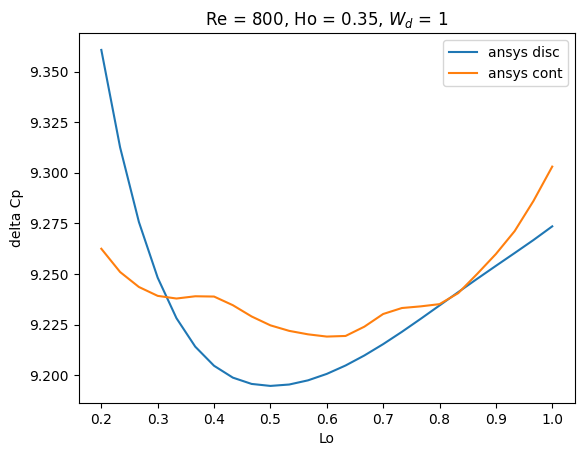

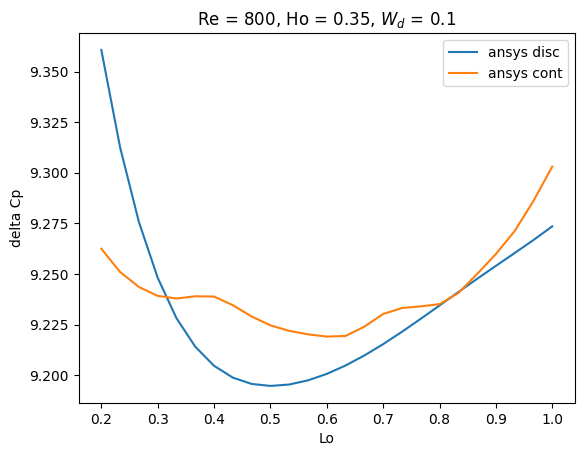

In [21]:
# Read Response Results

import csv
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
from shortNames import shortNameDict

# shortNameDict = {
#     "data1800PlusPhysicsLambda1": "D+P$\_W_d1$",
#     # "data1800PlusPhysicsLambda1": "D+P_L1",
#     "data1800PlusPhysicsLambda01": "D+P$\_W_d0.1$",
#     # "data1800PlusPhysicsLambda01": "D+P_L0.1",
#     "dataOnly1800": "D",
#     "physicsOnly": "P",
#     "physicsOnlyFC": "P FC",
#     "pressureDataPlusPhysicsLambda1": "PD+P",
#     "data1800PlusPhysicsLambda1FC" : "D+P\_FC$\_W_d1$",
#     "data1800PlusPhysicsLambda01FC" : "D+P\_FC$\_W_d01$",
#     "2pO": "ToP"
# }

# resultsFilePath="./resultsOpt.csv"

# dirSkip = ["dataOnly1800@500k", "pressureDataPlusPhysicsLambda1@500k", ""]

resultsPath = "./responseResults/"

# models = ["physicsOnly@500k", "data1800PlusPhysicsLambda01@300k"]
# models = ["physicsOnly@500k", "data1800PlusPhysicsLambda01@500k"]
models = listdir(resultsPath)
models.sort()

models = ["physicsOnlyFC@500k", "physicsOnly@500k", "dataOnly1800FC@500k", "dataOnly1800@500k"]
# models = ["data1800PlusPhysicsLambda1FC@500k", "data1800PlusPhysicsLambda1@500k", "data1800PlusPhysicsLambda01FC@500k", "data1800PlusPhysicsLambda01@500k"]

for L in ["1", "0.1"]:
    for reNr in [800]:
        # for HoV in [0.35, 0.4, 0.45]:
        for HoV in [0.35]:
        # for HoV in [0.2, 0.3, 0.4]:
            title = "Re = " + str(reNr) + ", Ho = " + str(HoV) + ", $W_d$ = " + L
            plt.figure()
            plt.title(title)
            
            #plot ansys response for comparison
            ansysFilePath = "./AnsysResponseRe" + str(reNr) + "Ho" + str(HoV) + ".csv"
            with open(ansysFilePath, "r") as ansysFile:
                x_vals_ans = []
                y_vals_ans = []
                reader = csv.reader(ansysFile, delimiter=",")
                for i in range(8):
                        reader.__next__()
                for row in reader:
                    x_vals_ans.append(float(row[0]))
                    y_vals_ans.append(float(row[1]))
            
            plt.plot(x_vals_ans, y_vals_ans, label="ansys disc")
            
            ansysFilePath = "./AnsysResponse100Re" + str(reNr) + "Ho" + str(HoV) + ".csv"
            with open(ansysFilePath, "r") as ansysFile:
                x_vals_ans = []
                y_vals_ans = []
                reader = csv.reader(ansysFile, delimiter=",")
                for i in range(8):
                        reader.__next__()
                for row in reader:
                    x_vals_ans.append(float(row[0]))
                    y_vals_ans.append(float(row[1]))
            
            plt.plot(x_vals_ans, y_vals_ans, label="ansys cont")

            #plot response for modulus models
            for model in models:
                if model in dirSkip:
                # if model in dirSkip or ("Lambda" + L.replace(".", "") not in model and "data" in model):
                    print("skipping ", model)
                    continue
                        
                path = resultsPath + model

                designs = np.load(path + "/designsRe" + str(reNr) + "Ho" + str(HoV) + ".npy")
                results = np.load(path + "/resultsRe" + str(reNr) + "Ho" + str(HoV) + ".npy")
                
                # designs = np.load(path + "/designsRe" + str(reNr) + "Lo" + str(HoV) + ".npy")
                # results = np.load(path + "/resultsRe" + str(reNr) + "Lo" + str(HoV) + ".npy")

                x_vals = [val[0] for val in designs]
                # x_vals = [val[1] for val in designs]
                
                modelStrSplit = model.split("@")
                
                if len(modelStrSplit) == 3:
                    label = shortNameDict[modelStrSplit[0]] + "@" + modelStrSplit[1].split("k")[0] + "k_" + shortNameDict[modelStrSplit[1].split("k")[-1]]
                elif len(modelStrSplit) == 2:
                    label = shortNameDict[modelStrSplit[0]]
                
                plt.plot(x_vals, results, label=label)
                
            plt.legend()
            plt.xlabel("Lo")
            plt.ylabel("delta Cp")
            plt.savefig(title + ".png", dpi = 600)

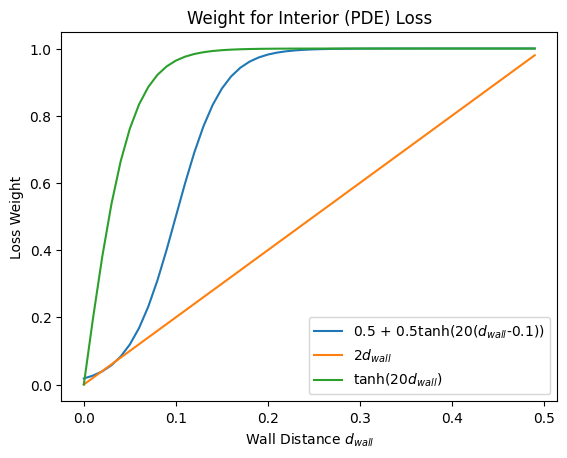

In [11]:
# plot lambda
from sympy import tanh
import matplotlib.pyplot as plt

x = np.arange(0, 0.5, 0.01)
y1 = np.array([0.5 + 0.5*tanh(20 * (xi-0.1)) for xi in x])
y2 = np.array([xi*2 for xi in x])
y3 = np.array([tanh(20 * (xi)) for xi in x])


title = "Weight for Interior (PDE) Loss"

plt.figure()
plt.title(title)



plt.plot(x, y1, label="0.5 + 0.5tanh(20($d_{wall}$-0.1))")
plt.plot(x, y2, label="2$d_{wall}$")
plt.plot(x, y3, label="tanh(20$d_{wall}$)")


    
    
plt.legend()
plt.xlabel("Wall Distance $d_{wall}$")
plt.ylabel("Loss Weight")
plt.savefig("lossWeight" + ".png", dpi = 600)

In [7]:
data = []

In [9]:
data.append(["a", "b"])

In [10]:
data

[['a', 'b']]

In [11]:
data.append(["c", "d"])

In [12]:
data

[['a', 'b'], ['c', 'd']]

In [13]:
s = "FC D+P $W_d=1$"

In [17]:
s.replace('$.*$', '')

'FC D+P $W_d=1$'

In [16]:
s

'FC D+P $W_d=1$'

In [46]:
c

array([0., 0., 0.])

In [59]:
# clean monitor directories
outputsPath = "./outputs/fwdFacingStep"
filePattern = "*/monitors/*.csv"
filePaths = glob.glob(os.path.join(outputsPath, filePattern))
for file_path in filePaths:
    if "_design_" in file_path:
        os.remove(file_path)